# Imports

In [164]:
%run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
#%run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb


all UiB paths loaded


In [165]:
%run /Home/siv30/wad005/master/GRB/src/read_matlab_file.ipynb
%run /Home/siv30/wad005/master/GRB/src/LC_calibration.ipynb

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re, sys

from astropy.io import fits, ascii
from astropy.time import Time
from stingray import Lightcurve as LC
from stingray import CrossCorrelation
from dateutil import parser

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

#%matplotlib inline

CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Notes on the GRB

    GRB: Possible NS (magnetar) - BH merger
    >> See paper: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2205.05031.pdf
    >> pre-cursor could be explained by the strong magnetic field creating a barrier and halting radius for accretion
    
    Angles: Which angles to use? From FERMI or SWIFT-XRT?
    >> Angle seperation above 60 deg for both BGO detectors
    
    ToF: Missing ToF from KW to ASIM.
    >> Ask Anastasia from this
    
    LC: Very long GRB that last for T0+80s.
    >> Main event last for around T0+12.5s (in na2 detector)
    
    XSPEC: Uncertanty problem solved by grouping channels!
    >> but still hard to produce a good fit
    >> Aible to produce a good fit for the second (main) peak. 1.2 fit statistics
    >> Trying now to fit the two main peaks.
    
    
    >>In the circular the GBM team fitted this burst with a Band-function with E-peak on the interval: T0-1.264 s to T0+54.033

# TODO
    -Cross corrolate FERMI/KW lc and bring FERMI lc into KW ref frame
        -KW lc have 2ms bin up to 0.512 s after T0
        -Problem when creating the lightcurve object for KW --> KW are already binned!
    
    -Change RA-DEC_OBJ parameters in the PHA file
    
    
    -Extract spectra from T0+0.0 to T0+0.064s

# Paths

In [167]:
GRB_id = "GRB201227A"
bn='bn201227635' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open
print(data_dir)

/Home/siv30/wad005/master/GRB_local/FERMI_data/bn201227635/


# Find the angle of the GRB wrt the GBM units

In [168]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

glg_trigdat_all_bn201227635_v01.fit
630774852.414564
['n4', 'n8']


In [169]:
grb_ra, grb_dec = 170.121,-73.613 #grb_ra is set to 106.1833 in pha file??  106.1833, -77.117

In [170]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


n4 45.002
n8 67.702
b0 72.906
n5 75.347
n3 91.187
nb 104.305
b1 107.094
n7 107.96
n2 113.344
n6 124.796
n1 132.295
na 134.225
n0 138.508
n9 165.202


# Find temporal offset between GBM trigger time and others

In [6]:
from gbm.time import Met
import datetime

# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?

ToF_Fermi_ASIM = -0.0008 #light travel time in seconds
ToF_KW_ASIM = 0.7142 
str_t0KW = '2020-12-27T15:14:06.705' #T0 for KW
t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met

#Q: Why are we adding both ToF? Double check this
t0MET = t0METKW.add(ToF_KW_ASIM+ToF_Fermi_ASIM)  # To add seconds
tshift = t0MET - t0METgbm
print(tshift) #shift between KW trigger and GBM trigger is <4ms 

0.00383603572845459


#  Extract data from selected unit(s)+

In [171]:
unit = all_dets[idx_sort_angsep][2] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v03.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b0


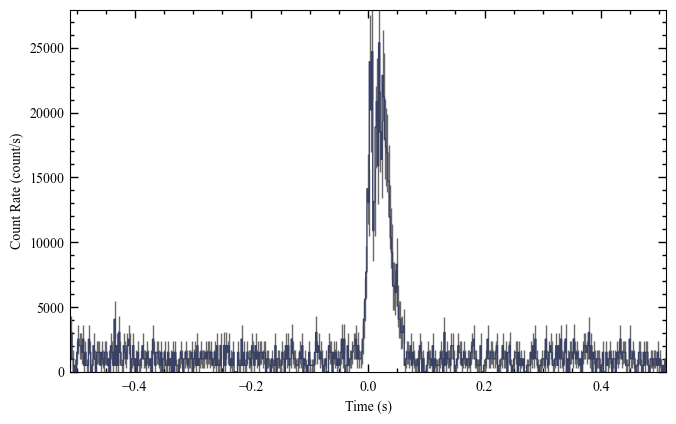

In [204]:
# open a TTE file
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = 0.002 # 2ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8, 1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange) #lightcurve binned by the given bint?
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.512,.512)

### Cross Corrolate KW and FERMI lc

In [184]:
i_start,i_end = find_nearest(tte.data.time,-0.512), find_nearest(tte.data.time,0.512)
print(i_start,i_end)

250902 253739


In [209]:
tte.data.time

array([-137.21789193, -137.21693003, -137.21632004, ...,  477.19203603,
        477.19209206,  477.19269001])

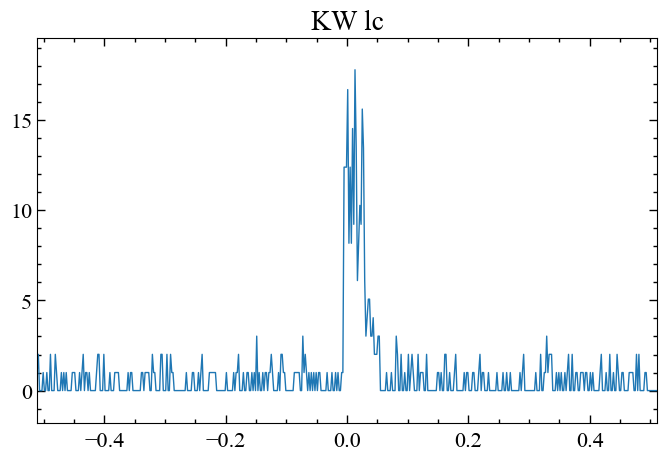

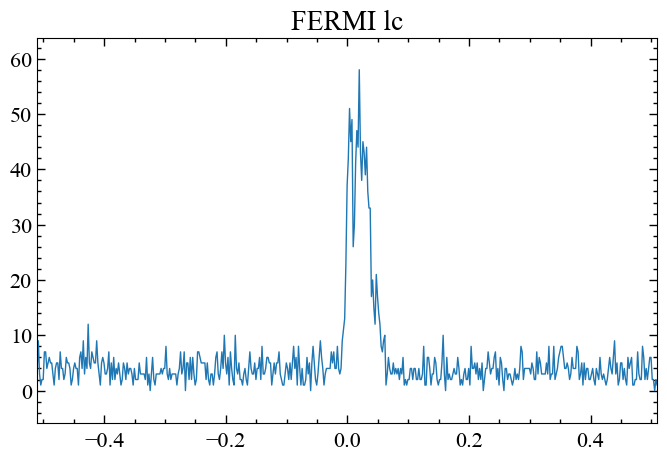

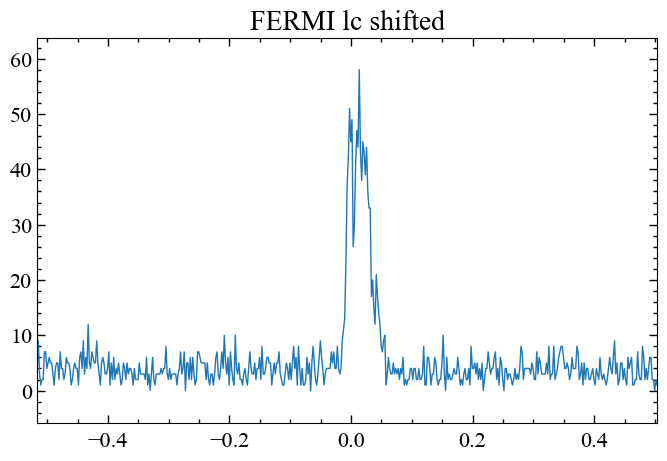

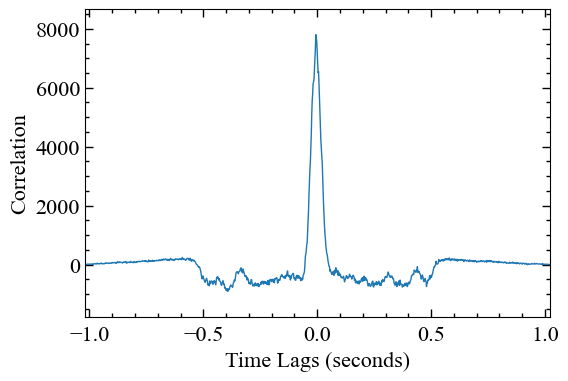

tshift (s)  -0.006
tshift rounded to .6E


In [215]:
tshift = cross_corrolate(tus_F = tte.data.time, kw_filename="GRB201227A_2ms.txt",binsize=0.002)
#tshift (s)  -0.006

In [213]:
def cross_corrolate(tus_F=None, kw_filename=None, binsize=None):
    """
    cross corrolation function between FERMI and KW. Function will itself bin the photon array and return the desired t_shift lag to shift the data into KW ref frame.
    
    Add t_shift to FERMI lc to bring it into KW ref frame.
    
    Note: Only the bins specified by binsize will be used in KW data. 
    
    input:
    --------------------------------------
    tus_F <np.array>: tus array given in seconds
    kw_filename <str>: filename.
    binsize <float>: given in seconds
    
    return:
    --------------------------------------
    t_shift <float>: given in us. Rounded to 6 sig figures """
    

    
    #KW handling------------------------------------------------------------------------------
    if str(int(binsize*1e3)) != kw_filename[kw_filename.find('_')+1:-6]:
        return print('filename and binsize is not correct')
    
    kw_file = kw_lc_path + kw_filename
    kw_df = pd.read_csv(kw_file,sep='\s+')
    kw_bin_lo, kw_bin_hi, G3 = kw_df["Ti"].to_numpy(), kw_df["Tf"].to_numpy(), kw_df["G3"].to_numpy()
    kw_dt = np.round(np.diff(kw_bin_lo),3)
    i_stop_kw = np.where(kw_dt>binsize)[0][0]
    
    kw_bin_lo, kw_bin_hi, G3 = kw_bin_lo[:i_stop_kw], kw_bin_right[:i_stop_kw], G3[:i_stop_kw]

    kw_lc = LC(time=kw_bin_lo + binsize/2, counts=G3,skip_checks=True,dt=binsize)

    check_alignment = [np.all(np.round(kw_lc.bin_lo,3) == kw_bin_lo),
                       np.all(np.round(kw_lc.bin_hi,3) == kw_bin_hi), 
                       np.all(np.round(kw_lc.counts,3) == G3)]

    for i, bool_ in enumerate(check_alignment):
        if bool_ == False:
            print(i)
            if i == 0:
                 print("bin_lo not aligned")
            elif i == 1:
                 print("bin_hi not aligned")
            elif i == 2:
                 print("counts not aligned")
                    
    #FERMI handling-------------------------
    kw_first_t, kw_last_t = find_nearest(tus_F,kw_bin_lo[0]), find_nearest(tus_F,kw_bin_hi[-1])
    tus_F = tus_F[kw_first_t:kw_last_t]    
    fermi_lc = LC.make_lightcurve(tus_F, dt=binsize)

    
    # Cross corrolating and shifting Fermi
    CC = CrossCorrelation(kw_lc,fermi_lc,mode="full")
    t_shift = np.round(CC.cal_timeshift(dt=binsize)[0],6)
    fermi_lc_shifted = fermi_lc.shift(CC.time_shift)
    
    #Plotting -----------------------------
    kw_lc.plot(title="KW lc")
    fermi_lc.plot(title="FERMI lc")
    fermi_lc_shifted.plot(title="FERMI lc shifted")
    CC.plot(labels = ['Time Lags (seconds)','Correlation'])
    
    print("tshift (s) ", t_shift)
    print("tshift rounded to .6E")
    return t_shift

In [9]:
# Fit background
bkgd_times = [(-100, -25), (50,100)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

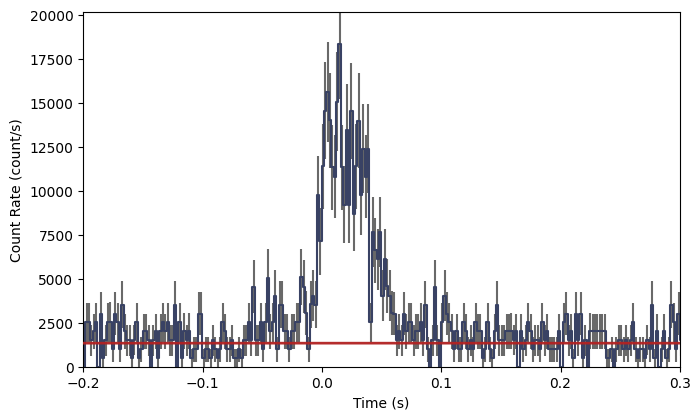

In [10]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.2,0.3)
lcplot.xlim = view_range

In [11]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([334.07354467,  75.80737805,  64.92180753,  49.95658674,
        32.30604334,  25.4604312 ,  18.15443184,  11.85339581,
        10.39398024,   9.54101357,   9.74094431,   9.65085159,
        10.17586692,  10.38619785,   9.65736195,  11.11510811,
        11.59517806,  12.25725563,  13.70722604,  15.19731371,
        13.3589575 ,  13.42475899,  14.84040932,  17.45232424,
        21.23913022,  25.63048821,  31.51904632,  35.79168276,
        38.68740463,  39.10574559,  41.01243597,  42.56592607,
        43.671823  ,  40.39329145,  42.48972442,  43.97910482,
        49.88555621,  45.49029092,  39.99759947,  39.45383899,
        37.04519882,  45.8915622 ,  58.82142769,  60.3652009 ,
        64.73002119,  63.79637406,  64.674123  ,  67.21351918,
        75.55747193,  71.25791749,  75.65596999,  83.22626001,
        81.37213717,  85.52274318,  89.2358102 ,  89.589813  ,
        98.61891666,  97.3170586 , 105.70872873, 104.60465765,
       104.03999383, 104.94154475, 106.43909741, 102.94

In [12]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= 0.00106  std= 0.998
NormaltestResult(statistic=3473.9387668400304, pvalue=0.0)


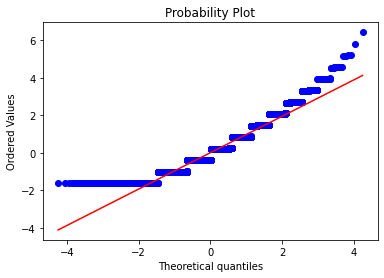

In [13]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

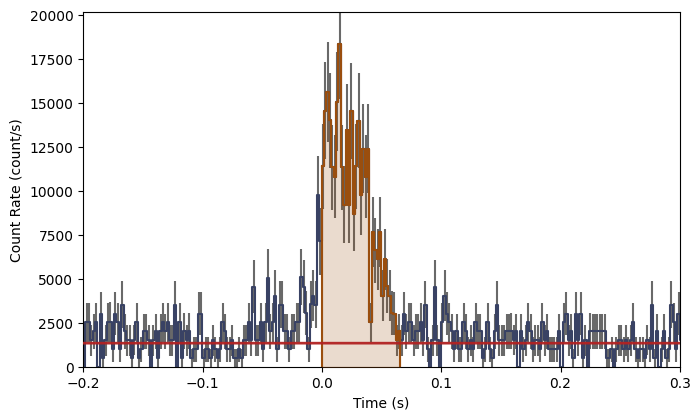

In [14]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (0,0.064) #64 ms exposure time (same as KW)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

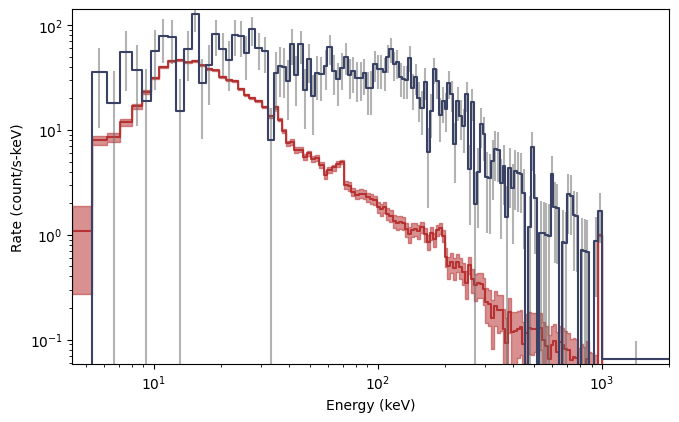

In [15]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [16]:
# Extract the corresponding PHA from source and bkg files
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

In [17]:
# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")

fparkey GRB201227A_n4.rsp GRB201227A_n4.pha+2 RESPFILE


# Time intervals for spectra

In [18]:
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
